# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower overall ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

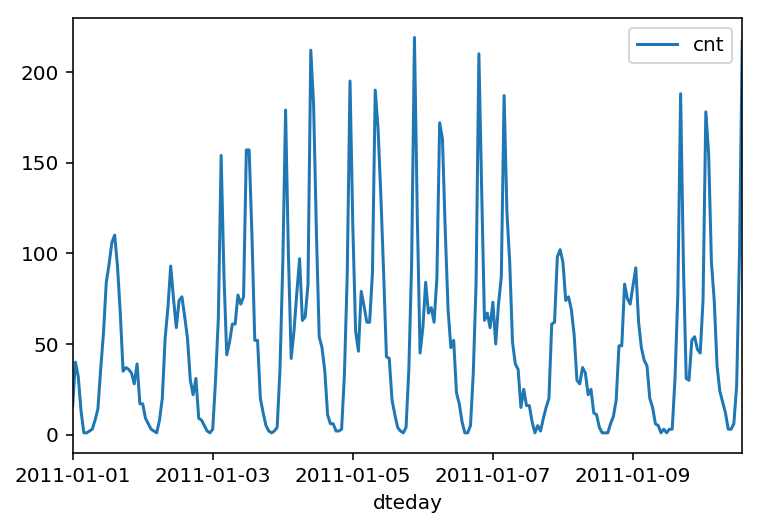

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement the forward pass and backward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. _The output layer has only one node and is used for the **regression**. The output of the node is **continuous** (number of rides) and the same as the input of the node. That is, the activation function is $f(x)=x$._ A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### Set self.activation_function to sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp( -x ))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]

        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)

        ## Training ##
        for X, y in zip(features, targets):
            ### Forward pass ###

            #### Hidden layer ####
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)  # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs)  # signals from hidden layer

            #### Output layer ####
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)  # signals into final output layer
            # Note: The output node is a regression node, so activation function is the identity f(x)=x
            final_outputs = final_inputs  # signals from final output layer
            
            ### Backward pass ###

            #### Output layer ####
            error = y - final_outputs  # Output layer error is the difference between desired target and actual output.
            # Note: The derivative of f(x)=x is 1
            output_error_term = error * 1.0
            
#             print("DEBUG: error={}".format(error))

            #### Hidden layer ####
            # The shape of the hidden layer's error is the same as the shape of the hidden layer output
            hidden_error = output_error_term * self.weights_hidden_to_output
            # The shape of hidden error term should be such that X.T * delta_h should have the shape of i2h
            # Note: Efficiency shortcut using the fact that sig_prime(x) = sig(x) * (1-sig(x))
            hidden_error_term = (hidden_outputs * (1-hidden_outputs)) * hidden_error.T
            
            ### Weight step ###

            # Input to hidden)
            delta_weights_i_h += X[:, None] * hidden_error_term

            # Hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        ## Weight update ##
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records  # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records  # update input-to-hidden weights with gradient descent step
        
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        ## Forward pass ##
        # Hidden layer
        hidden_inputs = features.dot(self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer
        final_inputs = hidden_outputs.dot(self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs  # Note: If 'features' is a pd.DF, so is 'final_outputs'!

In [10]:
def MSE(y, Y):
    return np.mean((y - Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [11]:
import unittest

# seed the random module for repeatability
np.random.seed(41)

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.004s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [12]:
import sys
from tqdm import tnrange, tqdm_notebook

### Set the hyperparameters here ###
# iterations = [1000, 5000]
# learning_rate = [0.01, 0.1]
# hidden_nodes = [2, 3, 4]
# output_nodes = 1
iterations = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000] # 8
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]              # 6
hidden_nodes = [2, 3, 4, 5, 6, 7, 8, 9, 10]                       # 9
output_nodes = 1

N_i = train_features.shape[1]

all_losses = {}
for hh in tqdm_notebook(hidden_nodes, desc='Hidden nodes'):

    for ll in tqdm_notebook(learning_rate, desc='Learning rate'):
    
        for it in tqdm_notebook(iterations, desc='Iterations'):
            
            # TODO: Mini-batch, weight-update variations, different neurons
            network = NeuralNetwork(N_i, hh, output_nodes, ll)    
            losses = {'network':network, 'train':[], 'validation':[]}

            for ii in tnrange(it):

                # Go through a random batch of 128 records from the training data set
                batch = np.random.choice(train_features.index, size=128)    
                # Note: ix[] is deprecated, using iloc[]
                X, y = train_features.loc[batch].values, train_targets.iloc[batch]['cnt']

                network.train(X, y)  # TODO: Mini-batch, weight-update variations, different neurons

                # Note: Because train_features is a pd.DF, so is the result of NN.run(), and this screws up np.mean()
                train_loss = MSE(network.run(train_features.values).T, train_targets['cnt'].values)
                val_loss   = MSE(network.run(val_features.values).T, val_targets['cnt'].values)

                sys.stdout.write("\rProgress ({0:2d}, {1:5.3f}, {2:6d}): {3:5.1f}% ... Training loss: {4:5.3f} ... Validation loss: {5:5.3f}".format(\
                                 hh, ll, it,
                                 100 * ii/float(it),
                                 train_loss,
                                 val_loss))
                sys.stdout.flush()

                losses['train'].append(train_loss)
                losses['validation'].append(val_loss)
                
            all_losses[(hh, ll, it)] = losses
    


Progress ( 2, 0.001,    100):  99.0% ... Training loss: 1.014 ... Validation loss: 1.652

Progress ( 2, 0.001,    500):  99.8% ... Training loss: 1.236 ... Validation loss: 1.350

Progress ( 2, 0.001,   1000):  99.9% ... Training loss: 1.055 ... Validation loss: 1.278

Progress ( 2, 0.001,   5000): 100.0% ... Training loss: 0.953 ... Validation loss: 1.368

Progress ( 2, 0.001,  10000): 100.0% ... Training loss: 0.961 ... Validation loss: 1.309

Progress ( 2, 0.001,  50000): 100.0% ... Training loss: 0.510 ... Validation loss: 0.837

Progress ( 2, 0.001, 100000): 100.0% ... Training loss: 0.306 ... Validation loss: 0.495

Progress ( 2, 0.001, 500000): 100.0% ... Training loss: 0.220 ... Validation loss: 0.372

Progress ( 2, 0.005,    100):  99.0% ... Training loss: 1.048 ... Validation loss: 1.274

Progress ( 2, 0.005,    500):  99.8% ... Training loss: 0.979 ... Validation loss: 1.333

Progress ( 2, 0.005,   1000):  99.9% ... Training loss: 0.973 ... Validation loss: 1.387

Progress ( 2, 0.005,   5000): 100.0% ... Training loss: 0.659 ... Validation loss: 1.097

Progress ( 2, 0.005,  10000): 100.0% ... Training loss: 0.569 ... Validation loss: 0.972

Progress ( 2, 0.005,  50000): 100.0% ... Training loss: 0.268 ... Validation loss: 0.440

Progress ( 2, 0.005, 100000): 100.0% ... Training loss: 0.236 ... Validation loss: 0.400

Progress ( 2, 0.005, 500000): 100.0% ... Training loss: 0.161 ... Validation loss: 0.305

Progress ( 2, 0.010,    100):  99.0% ... Training loss: 0.952 ... Validation loss: 1.467

Progress ( 2, 0.010,    500):  99.8% ... Training loss: 0.654 ... Validation loss: 1.068

Progress ( 2, 0.010,   1000):  99.9% ... Training loss: 0.875 ... Validation loss: 1.342

Progress ( 2, 0.010,   5000): 100.0% ... Training loss: 0.486 ... Validation loss: 0.796

Progress ( 2, 0.010,  10000): 100.0% ... Training loss: 0.367 ... Validation loss: 0.608

Progress ( 2, 0.010,  50000): 100.0% ... Training loss: 0.247 ... Validation loss: 0.409

Progress ( 2, 0.010, 100000): 100.0% ... Training loss: 0.220 ... Validation loss: 0.375

Progress ( 2, 0.010, 500000): 100.0% ... Training loss: 0.127 ... Validation loss: 0.232

Progress ( 2, 0.050,    100):  99.0% ... Training loss: 0.937 ... Validation loss: 1.316

Progress ( 2, 0.050,    500):  99.8% ... Training loss: 0.554 ... Validation loss: 0.903

Progress ( 2, 0.050,   1000):  99.9% ... Training loss: 0.436 ... Validation loss: 0.701

Progress ( 2, 0.050,   5000): 100.0% ... Training loss: 0.259 ... Validation loss: 0.425

Progress ( 2, 0.050,  10000): 100.0% ... Training loss: 0.244 ... Validation loss: 0.403

Progress ( 2, 0.050,  50000): 100.0% ... Training loss: 0.182 ... Validation loss: 0.279

Progress ( 2, 0.050, 100000): 100.0% ... Training loss: 0.136 ... Validation loss: 0.257

Progress ( 2, 0.050, 500000): 100.0% ... Training loss: 0.136 ... Validation loss: 0.248

Progress ( 2, 0.100,    100):  99.0% ... Training loss: 0.852 ... Validation loss: 1.320

Progress ( 2, 0.100,    500):  99.8% ... Training loss: 0.441 ... Validation loss: 0.714

Progress ( 2, 0.100,   1000):  99.9% ... Training loss: 0.313 ... Validation loss: 0.504

Progress ( 2, 0.100,   5000): 100.0% ... Training loss: 0.236 ... Validation loss: 0.394

Progress ( 2, 0.100,  10000): 100.0% ... Training loss: 0.221 ... Validation loss: 0.385

Progress ( 2, 0.100,  50000): 100.0% ... Training loss: 0.132 ... Validation loss: 0.237

Progress ( 2, 0.100, 100000): 100.0% ... Training loss: 0.093 ... Validation loss: 0.175

Progress ( 2, 0.100, 500000): 100.0% ... Training loss: 0.116 ... Validation loss: 0.215

Progress ( 2, 0.500,    100):  99.0% ... Training loss: 0.445 ... Validation loss: 0.717

Progress ( 2, 0.500,    500):  99.8% ... Training loss: 0.262 ... Validation loss: 0.428

Progress ( 2, 0.500,   1000):  99.9% ... Training loss: 0.215 ... Validation loss: 0.356

Progress ( 2, 0.500,   5000): 100.0% ... Training loss: 0.176 ... Validation loss: 0.332

Progress ( 2, 0.500,  10000): 100.0% ... Training loss: 0.141 ... Validation loss: 0.250

Progress ( 2, 0.500,  50000): 100.0% ... Training loss: 0.132 ... Validation loss: 0.246

Progress ( 2, 0.500, 100000): 100.0% ... Training loss: 0.132 ... Validation loss: 0.230

Progress ( 2, 0.500, 500000): 100.0% ... Training loss: 0.139 ... Validation loss: 0.260

Progress ( 3, 0.001,    100):  99.0% ... Training loss: 1.234 ... Validation loss: 1.949

Progress ( 3, 0.001,    500):  99.8% ... Training loss: 0.950 ... Validation loss: 1.418

Progress ( 3, 0.001,   1000):  99.9% ... Training loss: 1.007 ... Validation loss: 1.602

Progress ( 3, 0.001,   5000): 100.0% ... Training loss: 0.903 ... Validation loss: 1.350

Progress ( 3, 0.001,  10000): 100.0% ... Training loss: 0.791 ... Validation loss: 1.247

Progress ( 3, 0.001,  50000): 100.0% ... Training loss: 0.475 ... Validation loss: 0.777

Progress ( 3, 0.001, 100000): 100.0% ... Training loss: 0.320 ... Validation loss: 0.516

Progress ( 3, 0.001, 500000): 100.0% ... Training loss: 0.236 ... Validation loss: 0.403

Progress ( 3, 0.005,    100):  99.0% ... Training loss: 0.989 ... Validation loss: 1.695

Progress ( 3, 0.005,    500):  99.8% ... Training loss: 0.962 ... Validation loss: 1.320

Progress ( 3, 0.005,   1000):  99.9% ... Training loss: 0.729 ... Validation loss: 1.238

Progress ( 3, 0.005,   5000): 100.0% ... Training loss: 0.585 ... Validation loss: 1.012

Progress ( 3, 0.005,  10000): 100.0% ... Training loss: 0.525 ... Validation loss: 0.883

Progress ( 3, 0.005,  50000): 100.0% ... Training loss: 0.264 ... Validation loss: 0.430

Progress ( 3, 0.005, 100000): 100.0% ... Training loss: 0.240 ... Validation loss: 0.407

Progress ( 3, 0.005, 500000): 100.0% ... Training loss: 0.078 ... Validation loss: 0.164

Progress ( 3, 0.010,    100):  99.0% ... Training loss: 0.909 ... Validation loss: 1.388

Progress ( 3, 0.010,    500):  99.8% ... Training loss: 0.927 ... Validation loss: 1.340

Progress ( 3, 0.010,   1000):  99.9% ... Training loss: 0.673 ... Validation loss: 1.124

Progress ( 3, 0.010,   5000): 100.0% ... Training loss: 0.522 ... Validation loss: 0.869

Progress ( 3, 0.010,  10000): 100.0% ... Training loss: 0.308 ... Validation loss: 0.493

Progress ( 3, 0.010,  50000): 100.0% ... Training loss: 0.226 ... Validation loss: 0.404

Progress ( 3, 0.010, 100000): 100.0% ... Training loss: 0.197 ... Validation loss: 0.343

Progress ( 3, 0.010, 500000): 100.0% ... Training loss: 0.080 ... Validation loss: 0.165

Progress ( 3, 0.050,    100):  99.0% ... Training loss: 0.755 ... Validation loss: 1.255

Progress ( 3, 0.050,    500):  99.8% ... Training loss: 0.639 ... Validation loss: 1.081

Progress ( 3, 0.050,   1000):  99.9% ... Training loss: 0.390 ... Validation loss: 0.645

Progress ( 3, 0.050,   5000): 100.0% ... Training loss: 0.258 ... Validation loss: 0.422

Progress ( 3, 0.050,  10000): 100.0% ... Training loss: 0.234 ... Validation loss: 0.394

Progress ( 3, 0.050,  50000): 100.0% ... Training loss: 0.085 ... Validation loss: 0.168

Progress ( 3, 0.050, 100000): 100.0% ... Training loss: 0.080 ... Validation loss: 0.168

Progress ( 3, 0.050, 500000): 100.0% ... Training loss: 0.068 ... Validation loss: 0.138

Progress ( 3, 0.100,    100):  99.0% ... Training loss: 0.855 ... Validation loss: 1.360

Progress ( 3, 0.100,    500):  99.8% ... Training loss: 0.475 ... Validation loss: 0.778

Progress ( 3, 0.100,   1000):  99.9% ... Training loss: 0.303 ... Validation loss: 0.484

Progress ( 3, 0.100,   5000): 100.0% ... Training loss: 0.237 ... Validation loss: 0.400

Progress ( 3, 0.100,  10000): 100.0% ... Training loss: 0.180 ... Validation loss: 0.329

Progress ( 3, 0.100,  50000): 100.0% ... Training loss: 0.065 ... Validation loss: 0.138

Progress ( 3, 0.100, 100000): 100.0% ... Training loss: 0.062 ... Validation loss: 0.130

Progress ( 3, 0.100, 500000): 100.0% ... Training loss: 0.067 ... Validation loss: 0.138

Progress ( 3, 0.500,    100):  99.0% ... Training loss: 0.453 ... Validation loss: 0.742

Progress ( 3, 0.500,    500):  99.8% ... Training loss: 0.263 ... Validation loss: 0.428

Progress ( 3, 0.500,   1000):  99.9% ... Training loss: 0.246 ... Validation loss: 0.417

Progress ( 3, 0.500,   5000): 100.0% ... Training loss: 0.093 ... Validation loss: 0.173

Progress ( 3, 0.500,  10000): 100.0% ... Training loss: 0.077 ... Validation loss: 0.167

Progress ( 3, 0.500,  50000): 100.0% ... Training loss: 0.072 ... Validation loss: 0.145

Progress ( 3, 0.500, 100000): 100.0% ... Training loss: 0.063 ... Validation loss: 0.135

Progress ( 3, 0.500, 500000): 100.0% ... Training loss: 0.076 ... Validation loss: 0.151

Progress ( 4, 0.001,    100):  99.0% ... Training loss: 1.100 ... Validation loss: 1.632

Progress ( 4, 0.001,    500):  99.8% ... Training loss: 1.135 ... Validation loss: 1.304

Progress ( 4, 0.001,   1000):  99.9% ... Training loss: 0.904 ... Validation loss: 1.295

Progress ( 4, 0.001,   5000): 100.0% ... Training loss: 0.821 ... Validation loss: 1.241

Progress ( 4, 0.001,  10000): 100.0% ... Training loss: 0.726 ... Validation loss: 1.241

Progress ( 4, 0.001,  50000): 100.0% ... Training loss: 0.479 ... Validation loss: 0.787

Progress ( 4, 0.001, 100000): 100.0% ... Training loss: 0.306 ... Validation loss: 0.502

Progress ( 4, 0.001, 500000): 100.0% ... Training loss: 0.228 ... Validation loss: 0.397

Progress ( 4, 0.005,    100):  99.0% ... Training loss: 1.175 ... Validation loss: 1.364

Progress ( 4, 0.005,    500):  99.8% ... Training loss: 0.812 ... Validation loss: 1.331

Progress ( 4, 0.005,   1000):  99.9% ... Training loss: 0.888 ... Validation loss: 1.263

Progress ( 4, 0.005,   5000): 100.0% ... Training loss: 0.606 ... Validation loss: 1.069

Progress ( 4, 0.005,  10000): 100.0% ... Training loss: 0.486 ... Validation loss: 0.787

Progress ( 4, 0.005,  50000): 100.0% ... Training loss: 0.259 ... Validation loss: 0.437

Progress ( 4, 0.005, 100000): 100.0% ... Training loss: 0.235 ... Validation loss: 0.386

Progress ( 4, 0.005, 500000): 100.0% ... Training loss: 0.062 ... Validation loss: 0.139

Progress ( 4, 0.010,    100):  99.0% ... Training loss: 0.970 ... Validation loss: 1.530

Progress ( 4, 0.010,    500):  99.8% ... Training loss: 0.786 ... Validation loss: 1.272

Progress ( 4, 0.010,   1000):  99.9% ... Training loss: 0.683 ... Validation loss: 1.125

Progress ( 4, 0.010,   5000): 100.0% ... Training loss: 0.405 ... Validation loss: 0.658

Progress ( 4, 0.010,  10000): 100.0% ... Training loss: 0.309 ... Validation loss: 0.500

Progress ( 4, 0.010,  50000): 100.0% ... Training loss: 0.218 ... Validation loss: 0.378

Progress ( 4, 0.010, 100000): 100.0% ... Training loss: 0.102 ... Validation loss: 0.221

Progress ( 4, 0.010, 500000): 100.0% ... Training loss: 0.077 ... Validation loss: 0.162

Progress ( 4, 0.050,    100):  99.0% ... Training loss: 0.867 ... Validation loss: 1.333

Progress ( 4, 0.050,    500):  99.8% ... Training loss: 0.622 ... Validation loss: 1.102

Progress ( 4, 0.050,   1000):  99.9% ... Training loss: 0.475 ... Validation loss: 0.770

Progress ( 4, 0.050,   5000): 100.0% ... Training loss: 0.250 ... Validation loss: 0.411

Progress ( 4, 0.050,  10000): 100.0% ... Training loss: 0.217 ... Validation loss: 0.374

Progress ( 4, 0.050,  50000): 100.0% ... Training loss: 0.074 ... Validation loss: 0.154

Progress ( 4, 0.050, 100000): 100.0% ... Training loss: 0.076 ... Validation loss: 0.164

Progress ( 4, 0.050, 500000): 100.0% ... Training loss: 0.066 ... Validation loss: 0.148

Progress ( 4, 0.100,    100):  99.0% ... Training loss: 0.689 ... Validation loss: 1.209

Progress ( 4, 0.100,    500):  99.8% ... Training loss: 0.438 ... Validation loss: 0.715

Progress ( 4, 0.100,   1000):  99.9% ... Training loss: 0.303 ... Validation loss: 0.482

Progress ( 4, 0.100,   5000): 100.0% ... Training loss: 0.216 ... Validation loss: 0.374

Progress ( 4, 0.100,  10000): 100.0% ... Training loss: 0.114 ... Validation loss: 0.220

Progress ( 4, 0.100,  50000): 100.0% ... Training loss: 0.063 ... Validation loss: 0.169

Progress ( 4, 0.100, 100000): 100.0% ... Training loss: 0.061 ... Validation loss: 0.134

Progress ( 4, 0.100, 500000): 100.0% ... Training loss: 0.056 ... Validation loss: 0.139

Progress ( 4, 0.500,    100):  99.0% ... Training loss: 0.387 ... Validation loss: 0.627

Progress ( 4, 0.500,    500):  99.8% ... Training loss: 0.261 ... Validation loss: 0.434

Progress ( 4, 0.500,   1000):  99.9% ... Training loss: 0.241 ... Validation loss: 0.408

Progress ( 4, 0.500,   5000): 100.0% ... Training loss: 0.075 ... Validation loss: 0.172

Progress ( 4, 0.500,  10000): 100.0% ... Training loss: 0.062 ... Validation loss: 0.149

Progress ( 4, 0.500,  50000): 100.0% ... Training loss: 0.059 ... Validation loss: 0.176

Progress ( 4, 0.500, 100000): 100.0% ... Training loss: 0.056 ... Validation loss: 0.173

Progress ( 4, 0.500, 500000): 100.0% ... Training loss: 0.061 ... Validation loss: 0.170

Progress ( 5, 0.001,    100):  99.0% ... Training loss: 1.057 ... Validation loss: 1.612

Progress ( 5, 0.001,    500):  99.8% ... Training loss: 0.990 ... Validation loss: 1.437

Progress ( 5, 0.001,   1000):  99.9% ... Training loss: 0.982 ... Validation loss: 1.427

Progress ( 5, 0.001,   5000): 100.0% ... Training loss: 0.789 ... Validation loss: 1.279

Progress ( 5, 0.001,  10000): 100.0% ... Training loss: 0.620 ... Validation loss: 1.059

Progress ( 5, 0.001,  50000): 100.0% ... Training loss: 0.451 ... Validation loss: 0.739

Progress ( 5, 0.001, 100000): 100.0% ... Training loss: 0.310 ... Validation loss: 0.492

Progress ( 5, 0.001, 500000): 100.0% ... Training loss: 0.241 ... Validation loss: 0.400

Progress ( 5, 0.005,    100):  99.0% ... Training loss: 1.019 ... Validation loss: 1.542

Progress ( 5, 0.005,    500):  99.8% ... Training loss: 0.950 ... Validation loss: 1.338

Progress ( 5, 0.005,   1000):  99.9% ... Training loss: 0.726 ... Validation loss: 1.235

Progress ( 5, 0.005,   5000): 100.0% ... Training loss: 0.581 ... Validation loss: 0.993

Progress ( 5, 0.005,  10000): 100.0% ... Training loss: 0.444 ... Validation loss: 0.745

Progress ( 5, 0.005,  50000): 100.0% ... Training loss: 0.260 ... Validation loss: 0.425

Progress ( 5, 0.005, 100000): 100.0% ... Training loss: 0.214 ... Validation loss: 0.380

Progress ( 5, 0.005, 500000): 100.0% ... Training loss: 0.070 ... Validation loss: 0.188

Progress ( 5, 0.010,    100):  99.0% ... Training loss: 0.906 ... Validation loss: 1.369

Progress ( 5, 0.010,    500):  99.8% ... Training loss: 0.828 ... Validation loss: 1.307

Progress ( 5, 0.010,   1000):  99.9% ... Training loss: 0.732 ... Validation loss: 1.276

Progress ( 5, 0.010,   5000): 100.0% ... Training loss: 0.445 ... Validation loss: 0.733

Progress ( 5, 0.010,  10000): 100.0% ... Training loss: 0.306 ... Validation loss: 0.488

Progress ( 5, 0.010,  50000): 100.0% ... Training loss: 0.243 ... Validation loss: 0.404

Progress ( 5, 0.010, 100000): 100.0% ... Training loss: 0.107 ... Validation loss: 0.208

Progress ( 5, 0.010, 500000): 100.0% ... Training loss: 0.056 ... Validation loss: 0.146

Progress ( 5, 0.050,    100):  99.0% ... Training loss: 0.940 ... Validation loss: 1.346

Progress ( 5, 0.050,    500):  99.8% ... Training loss: 0.606 ... Validation loss: 1.007

Progress ( 5, 0.050,   1000):  99.9% ... Training loss: 0.473 ... Validation loss: 0.775

Progress ( 5, 0.050,   5000): 100.0% ... Training loss: 0.257 ... Validation loss: 0.421

Progress ( 5, 0.050,  10000): 100.0% ... Training loss: 0.199 ... Validation loss: 0.354

Progress ( 5, 0.050,  50000): 100.0% ... Training loss: 0.063 ... Validation loss: 0.162

Progress ( 5, 0.050, 100000): 100.0% ... Training loss: 0.058 ... Validation loss: 0.153

Progress ( 5, 0.050, 500000): 100.0% ... Training loss: 0.052 ... Validation loss: 0.143

Progress ( 5, 0.100,    100):  99.0% ... Training loss: 0.742 ... Validation loss: 1.201

Progress ( 5, 0.100,    500):  99.8% ... Training loss: 0.435 ... Validation loss: 0.715

Progress ( 5, 0.100,   1000):  99.9% ... Training loss: 0.305 ... Validation loss: 0.484

Progress ( 5, 0.100,   5000): 100.0% ... Training loss: 0.211 ... Validation loss: 0.377

Progress ( 5, 0.100,  10000): 100.0% ... Training loss: 0.119 ... Validation loss: 0.243

Progress ( 5, 0.100,  50000): 100.0% ... Training loss: 0.061 ... Validation loss: 0.143

Progress ( 5, 0.100, 100000): 100.0% ... Training loss: 0.056 ... Validation loss: 0.150

Progress ( 5, 0.100, 500000): 100.0% ... Training loss: 0.051 ... Validation loss: 0.152

Progress ( 5, 0.500,    100):  99.0% ... Training loss: 0.414 ... Validation loss: 0.696

Progress ( 5, 0.500,    500):  99.8% ... Training loss: 0.270 ... Validation loss: 0.455

Progress ( 5, 0.500,   1000):  99.9% ... Training loss: 0.253 ... Validation loss: 0.428

Progress ( 5, 0.500,   5000): 100.0% ... Training loss: 0.071 ... Validation loss: 0.169

Progress ( 5, 0.500,  10000): 100.0% ... Training loss: 0.061 ... Validation loss: 0.159

Progress ( 5, 0.500,  50000): 100.0% ... Training loss: 0.055 ... Validation loss: 0.165

Progress ( 5, 0.500, 100000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.206

Progress ( 5, 0.500, 500000): 100.0% ... Training loss: 0.052 ... Validation loss: 0.234

Progress ( 6, 0.001,    100):  99.0% ... Training loss: 1.017 ... Validation loss: 1.410

Progress ( 6, 0.001,    500):  99.8% ... Training loss: 0.939 ... Validation loss: 1.232

Progress ( 6, 0.001,   1000):  99.9% ... Training loss: 0.955 ... Validation loss: 1.460

Progress ( 6, 0.001,   5000): 100.0% ... Training loss: 0.778 ... Validation loss: 1.314

Progress ( 6, 0.001,  10000): 100.0% ... Training loss: 0.659 ... Validation loss: 1.133

Progress ( 6, 0.001,  50000): 100.0% ... Training loss: 0.427 ... Validation loss: 0.705

Progress ( 6, 0.001, 100000): 100.0% ... Training loss: 0.305 ... Validation loss: 0.488

Progress ( 6, 0.001, 500000): 100.0% ... Training loss: 0.255 ... Validation loss: 0.428

Progress ( 6, 0.005,    100):  99.0% ... Training loss: 1.158 ... Validation loss: 1.310

Progress ( 6, 0.005,    500):  99.8% ... Training loss: 0.878 ... Validation loss: 1.315

Progress ( 6, 0.005,   1000):  99.9% ... Training loss: 0.724 ... Validation loss: 1.180

Progress ( 6, 0.005,   5000): 100.0% ... Training loss: 0.611 ... Validation loss: 1.080

Progress ( 6, 0.005,  10000): 100.0% ... Training loss: 0.458 ... Validation loss: 0.747

Progress ( 6, 0.005,  50000): 100.0% ... Training loss: 0.263 ... Validation loss: 0.438

Progress ( 6, 0.005, 100000): 100.0% ... Training loss: 0.238 ... Validation loss: 0.406

Progress ( 6, 0.005, 500000): 100.0% ... Training loss: 0.071 ... Validation loss: 0.159

Progress ( 6, 0.010,    100):  99.0% ... Training loss: 0.953 ... Validation loss: 1.400

Progress ( 6, 0.010,    500):  99.8% ... Training loss: 0.746 ... Validation loss: 1.337

Progress ( 6, 0.010,   1000):  99.9% ... Training loss: 0.704 ... Validation loss: 1.169

Progress ( 6, 0.010,   5000): 100.0% ... Training loss: 0.457 ... Validation loss: 0.745

Progress ( 6, 0.010,  10000): 100.0% ... Training loss: 0.306 ... Validation loss: 0.489

Progress ( 6, 0.010,  50000): 100.0% ... Training loss: 0.230 ... Validation loss: 0.390

Progress ( 6, 0.010, 100000): 100.0% ... Training loss: 0.179 ... Validation loss: 0.321

Progress ( 6, 0.010, 500000): 100.0% ... Training loss: 0.072 ... Validation loss: 0.163

Progress ( 6, 0.050,    100):  99.0% ... Training loss: 0.819 ... Validation loss: 1.250

Progress ( 6, 0.050,    500):  99.8% ... Training loss: 0.605 ... Validation loss: 1.020

Progress ( 6, 0.050,   1000):  99.9% ... Training loss: 0.469 ... Validation loss: 0.778

Progress ( 6, 0.050,   5000): 100.0% ... Training loss: 0.263 ... Validation loss: 0.434

Progress ( 6, 0.050,  10000): 100.0% ... Training loss: 0.226 ... Validation loss: 0.380

Progress ( 6, 0.050,  50000): 100.0% ... Training loss: 0.073 ... Validation loss: 0.167

Progress ( 6, 0.050, 100000): 100.0% ... Training loss: 0.059 ... Validation loss: 0.146

Progress ( 6, 0.050, 500000): 100.0% ... Training loss: 0.052 ... Validation loss: 0.208

Progress ( 6, 0.100,    100):  99.0% ... Training loss: 0.756 ... Validation loss: 1.247

Progress ( 6, 0.100,    500):  99.8% ... Training loss: 0.441 ... Validation loss: 0.739

Progress ( 6, 0.100,   1000):  99.9% ... Training loss: 0.317 ... Validation loss: 0.499

Progress ( 6, 0.100,   5000): 100.0% ... Training loss: 0.229 ... Validation loss: 0.395

Progress ( 6, 0.100,  10000): 100.0% ... Training loss: 0.103 ... Validation loss: 0.199

Progress ( 6, 0.100,  50000): 100.0% ... Training loss: 0.056 ... Validation loss: 0.174

Progress ( 6, 0.100, 100000): 100.0% ... Training loss: 0.055 ... Validation loss: 0.155

Progress ( 6, 0.100, 500000): 100.0% ... Training loss: 0.049 ... Validation loss: 0.331

Progress ( 6, 0.500,    100):  99.0% ... Training loss: 0.476 ... Validation loss: 0.782

Progress ( 6, 0.500,    500):  99.8% ... Training loss: 0.261 ... Validation loss: 0.436

Progress ( 6, 0.500,   1000):  99.9% ... Training loss: 0.221 ... Validation loss: 0.378

Progress ( 6, 0.500,   5000): 100.0% ... Training loss: 0.063 ... Validation loss: 0.158

Progress ( 6, 0.500,  10000): 100.0% ... Training loss: 0.079 ... Validation loss: 0.160

Progress ( 6, 0.500,  50000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.216

Progress ( 6, 0.500, 100000): 100.0% ... Training loss: 0.050 ... Validation loss: 0.167

Progress ( 6, 0.500, 500000): 100.0% ... Training loss: 0.050 ... Validation loss: 0.210

Progress ( 7, 0.001,    100):  99.0% ... Training loss: 1.110 ... Validation loss: 1.262

Progress ( 7, 0.001,    500):  99.8% ... Training loss: 0.955 ... Validation loss: 1.517

Progress ( 7, 0.001,   1000):  99.9% ... Training loss: 0.894 ... Validation loss: 1.341

Progress ( 7, 0.001,   5000): 100.0% ... Training loss: 0.815 ... Validation loss: 1.324

Progress ( 7, 0.001,  10000): 100.0% ... Training loss: 0.880 ... Validation loss: 1.304

Progress ( 7, 0.001,  50000): 100.0% ... Training loss: 0.426 ... Validation loss: 0.697

Progress ( 7, 0.001, 100000): 100.0% ... Training loss: 0.312 ... Validation loss: 0.499

Progress ( 7, 0.001, 500000): 100.0% ... Training loss: 0.233 ... Validation loss: 0.391

Progress ( 7, 0.005,    100):  99.0% ... Training loss: 0.956 ... Validation loss: 1.340

Progress ( 7, 0.005,    500):  99.8% ... Training loss: 0.887 ... Validation loss: 1.318

Progress ( 7, 0.005,   1000):  99.9% ... Training loss: 0.816 ... Validation loss: 1.279

Progress ( 7, 0.005,   5000): 100.0% ... Training loss: 0.591 ... Validation loss: 1.073

Progress ( 7, 0.005,  10000): 100.0% ... Training loss: 0.446 ... Validation loss: 0.726

Progress ( 7, 0.005,  50000): 100.0% ... Training loss: 0.264 ... Validation loss: 0.434

Progress ( 7, 0.005, 100000): 100.0% ... Training loss: 0.230 ... Validation loss: 0.394

Progress ( 7, 0.005, 500000): 100.0% ... Training loss: 0.063 ... Validation loss: 0.164

Progress ( 7, 0.010,    100):  99.0% ... Training loss: 0.973 ... Validation loss: 1.348

Progress ( 7, 0.010,    500):  99.8% ... Training loss: 0.808 ... Validation loss: 1.251

Progress ( 7, 0.010,   1000):  99.9% ... Training loss: 0.673 ... Validation loss: 1.167

Progress ( 7, 0.010,   5000): 100.0% ... Training loss: 0.478 ... Validation loss: 0.779

Progress ( 7, 0.010,  10000): 100.0% ... Training loss: 0.299 ... Validation loss: 0.473

Progress ( 7, 0.010,  50000): 100.0% ... Training loss: 0.245 ... Validation loss: 0.416

Progress ( 7, 0.010, 100000): 100.0% ... Training loss: 0.147 ... Validation loss: 0.283

Progress ( 7, 0.010, 500000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.154

Progress ( 7, 0.050,    100):  99.0% ... Training loss: 0.877 ... Validation loss: 1.357

Progress ( 7, 0.050,    500):  99.8% ... Training loss: 0.593 ... Validation loss: 1.024

Progress ( 7, 0.050,   1000):  99.9% ... Training loss: 0.423 ... Validation loss: 0.695

Progress ( 7, 0.050,   5000): 100.0% ... Training loss: 0.268 ... Validation loss: 0.451

Progress ( 7, 0.050,  10000): 100.0% ... Training loss: 0.235 ... Validation loss: 0.399

Progress ( 7, 0.050,  50000): 100.0% ... Training loss: 0.064 ... Validation loss: 0.166

Progress ( 7, 0.050, 100000): 100.0% ... Training loss: 0.056 ... Validation loss: 0.194

Progress ( 7, 0.050, 500000): 100.0% ... Training loss: 0.046 ... Validation loss: 0.221

Progress ( 7, 0.100,    100):  99.0% ... Training loss: 0.748 ... Validation loss: 1.259

Progress ( 7, 0.100,    500):  99.8% ... Training loss: 0.439 ... Validation loss: 0.713

Progress ( 7, 0.100,   1000):  99.9% ... Training loss: 0.306 ... Validation loss: 0.487

Progress ( 7, 0.100,   5000): 100.0% ... Training loss: 0.232 ... Validation loss: 0.416

Progress ( 7, 0.100,  10000): 100.0% ... Training loss: 0.156 ... Validation loss: 0.301

Progress ( 7, 0.100,  50000): 100.0% ... Training loss: 0.054 ... Validation loss: 0.142

Progress ( 7, 0.100, 100000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.191

Progress ( 7, 0.100, 500000): 100.0% ... Training loss: 0.048 ... Validation loss: 0.168

Progress ( 7, 0.500,    100):  99.0% ... Training loss: 0.435 ... Validation loss: 0.692

Progress ( 7, 0.500,    500):  99.8% ... Training loss: 0.281 ... Validation loss: 0.440

Progress ( 7, 0.500,   1000):  99.9% ... Training loss: 0.224 ... Validation loss: 0.377

Progress ( 7, 0.500,   5000): 100.0% ... Training loss: 0.065 ... Validation loss: 0.147

Progress ( 7, 0.500,  10000): 100.0% ... Training loss: 0.066 ... Validation loss: 0.145

Progress ( 7, 0.500,  50000): 100.0% ... Training loss: 0.051 ... Validation loss: 0.176

Progress ( 7, 0.500, 100000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.178

Progress ( 7, 0.500, 500000): 100.0% ... Training loss: 0.044 ... Validation loss: 0.199

Progress ( 8, 0.001,    100):  99.0% ... Training loss: 0.974 ... Validation loss: 1.364

Progress ( 8, 0.001,    500):  99.8% ... Training loss: 0.998 ... Validation loss: 1.306

Progress ( 8, 0.001,   1000):  99.9% ... Training loss: 0.896 ... Validation loss: 1.303

Progress ( 8, 0.001,   5000): 100.0% ... Training loss: 0.797 ... Validation loss: 1.322

Progress ( 8, 0.001,  10000): 100.0% ... Training loss: 0.688 ... Validation loss: 1.203

Progress ( 8, 0.001,  50000): 100.0% ... Training loss: 0.453 ... Validation loss: 0.743

Progress ( 8, 0.001, 100000): 100.0% ... Training loss: 0.322 ... Validation loss: 0.514

Progress ( 8, 0.001, 500000): 100.0% ... Training loss: 0.231 ... Validation loss: 0.390

Progress ( 8, 0.005,    100):  99.0% ... Training loss: 1.040 ... Validation loss: 1.575

Progress ( 8, 0.005,    500):  99.8% ... Training loss: 0.841 ... Validation loss: 1.295

Progress ( 8, 0.005,   1000):  99.9% ... Training loss: 0.801 ... Validation loss: 1.298

Progress ( 8, 0.005,   5000): 100.0% ... Training loss: 0.589 ... Validation loss: 1.035

Progress ( 8, 0.005,  10000): 100.0% ... Training loss: 0.437 ... Validation loss: 0.711

Progress ( 8, 0.005,  50000): 100.0% ... Training loss: 0.265 ... Validation loss: 0.441

Progress ( 8, 0.005, 100000): 100.0% ... Training loss: 0.223 ... Validation loss: 0.391

Progress ( 8, 0.005, 500000): 100.0% ... Training loss: 0.058 ... Validation loss: 0.152

Progress ( 8, 0.010,    100):  99.0% ... Training loss: 0.944 ... Validation loss: 1.382

Progress ( 8, 0.010,    500):  99.8% ... Training loss: 0.872 ... Validation loss: 1.320

Progress ( 8, 0.010,   1000):  99.9% ... Training loss: 0.773 ... Validation loss: 1.252

Progress ( 8, 0.010,   5000): 100.0% ... Training loss: 0.455 ... Validation loss: 0.751

Progress ( 8, 0.010,  10000): 100.0% ... Training loss: 0.306 ... Validation loss: 0.492

Progress ( 8, 0.010,  50000): 100.0% ... Training loss: 0.203 ... Validation loss: 0.350

Progress ( 8, 0.010, 100000): 100.0% ... Training loss: 0.169 ... Validation loss: 0.336

Progress ( 8, 0.010, 500000): 100.0% ... Training loss: 0.051 ... Validation loss: 0.147

Progress ( 8, 0.050,    100):  99.0% ... Training loss: 0.794 ... Validation loss: 1.227

Progress ( 8, 0.050,    500):  99.8% ... Training loss: 0.594 ... Validation loss: 1.026

Progress ( 8, 0.050,   1000):  99.9% ... Training loss: 0.411 ... Validation loss: 0.675

Progress ( 8, 0.050,   5000): 100.0% ... Training loss: 0.261 ... Validation loss: 0.428

Progress ( 8, 0.050,  10000): 100.0% ... Training loss: 0.232 ... Validation loss: 0.395

Progress ( 8, 0.050,  50000): 100.0% ... Training loss: 0.067 ... Validation loss: 0.184

Progress ( 8, 0.050, 100000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.162

Progress ( 8, 0.050, 500000): 100.0% ... Training loss: 0.047 ... Validation loss: 0.199

Progress ( 8, 0.100,    100):  99.0% ... Training loss: 0.747 ... Validation loss: 1.282

Progress ( 8, 0.100,    500):  99.8% ... Training loss: 0.484 ... Validation loss: 0.797

Progress ( 8, 0.100,   1000):  99.9% ... Training loss: 0.312 ... Validation loss: 0.490

Progress ( 8, 0.100,   5000): 100.0% ... Training loss: 0.241 ... Validation loss: 0.409

Progress ( 8, 0.100,  10000): 100.0% ... Training loss: 0.164 ... Validation loss: 0.305

Progress ( 8, 0.100,  50000): 100.0% ... Training loss: 0.061 ... Validation loss: 0.171

Progress ( 8, 0.100, 100000): 100.0% ... Training loss: 0.049 ... Validation loss: 0.156

Progress ( 8, 0.100, 500000): 100.0% ... Training loss: 0.046 ... Validation loss: 0.150

Progress ( 8, 0.500,    100):  99.0% ... Training loss: 0.465 ... Validation loss: 0.723

Progress ( 8, 0.500,    500):  99.8% ... Training loss: 0.265 ... Validation loss: 0.429

Progress ( 8, 0.500,   1000):  99.9% ... Training loss: 0.242 ... Validation loss: 0.411

Progress ( 8, 0.500,   5000): 100.0% ... Training loss: 0.071 ... Validation loss: 0.149

Progress ( 8, 0.500,  10000): 100.0% ... Training loss: 0.064 ... Validation loss: 0.176

Progress ( 8, 0.500,  50000): 100.0% ... Training loss: 0.051 ... Validation loss: 0.173

Progress ( 8, 0.500, 100000): 100.0% ... Training loss: 0.050 ... Validation loss: 0.234

Progress ( 8, 0.500, 500000): 100.0% ... Training loss: 0.042 ... Validation loss: 0.244

Progress ( 9, 0.001,    100):  99.0% ... Training loss: 1.237 ... Validation loss: 1.352

Progress ( 9, 0.001,    500):  99.8% ... Training loss: 0.898 ... Validation loss: 1.449

Progress ( 9, 0.001,   1000):  99.9% ... Training loss: 0.898 ... Validation loss: 1.381

Progress ( 9, 0.001,   5000): 100.0% ... Training loss: 0.885 ... Validation loss: 1.342

Progress ( 9, 0.001,  10000): 100.0% ... Training loss: 0.722 ... Validation loss: 1.259

Progress ( 9, 0.001,  50000): 100.0% ... Training loss: 0.454 ... Validation loss: 0.736

Progress ( 9, 0.001, 100000): 100.0% ... Training loss: 0.309 ... Validation loss: 0.487

Progress ( 9, 0.001, 500000): 100.0% ... Training loss: 0.223 ... Validation loss: 0.380

Progress ( 9, 0.005,    100):  99.0% ... Training loss: 1.010 ... Validation loss: 1.327

Progress ( 9, 0.005,    500):  99.8% ... Training loss: 0.858 ... Validation loss: 1.301

Progress ( 9, 0.005,   1000):  99.9% ... Training loss: 0.814 ... Validation loss: 1.261

Progress ( 9, 0.005,   5000): 100.0% ... Training loss: 0.619 ... Validation loss: 1.038

Progress ( 9, 0.005,  10000): 100.0% ... Training loss: 0.374 ... Validation loss: 0.618

Progress ( 9, 0.005,  50000): 100.0% ... Training loss: 0.258 ... Validation loss: 0.428

Progress ( 9, 0.005, 100000): 100.0% ... Training loss: 0.236 ... Validation loss: 0.393

Progress ( 9, 0.005, 500000): 100.0% ... Training loss: 0.060 ... Validation loss: 0.153

Progress ( 9, 0.010,    100):  99.0% ... Training loss: 0.978 ... Validation loss: 1.336

Progress ( 9, 0.010,    500):  99.8% ... Training loss: 0.795 ... Validation loss: 1.267

Progress ( 9, 0.010,   1000):  99.9% ... Training loss: 0.734 ... Validation loss: 1.241

Progress ( 9, 0.010,   5000): 100.0% ... Training loss: 0.460 ... Validation loss: 0.751

Progress ( 9, 0.010,  10000): 100.0% ... Training loss: 0.310 ... Validation loss: 0.488

Progress ( 9, 0.010,  50000): 100.0% ... Training loss: 0.246 ... Validation loss: 0.410

Progress ( 9, 0.010, 100000): 100.0% ... Training loss: 0.134 ... Validation loss: 0.252

Progress ( 9, 0.010, 500000): 100.0% ... Training loss: 0.052 ... Validation loss: 0.162

Progress ( 9, 0.050,    100):  99.0% ... Training loss: 0.830 ... Validation loss: 1.272

Progress ( 9, 0.050,    500):  99.8% ... Training loss: 0.599 ... Validation loss: 1.027

Progress ( 9, 0.050,   1000):  99.9% ... Training loss: 0.430 ... Validation loss: 0.704

Progress ( 9, 0.050,   5000): 100.0% ... Training loss: 0.272 ... Validation loss: 0.445

Progress ( 9, 0.050,  10000): 100.0% ... Training loss: 0.254 ... Validation loss: 0.434

Progress ( 9, 0.050,  50000): 100.0% ... Training loss: 0.064 ... Validation loss: 0.154

Progress ( 9, 0.050, 100000): 100.0% ... Training loss: 0.052 ... Validation loss: 0.191

Progress ( 9, 0.050, 500000): 100.0% ... Training loss: 0.046 ... Validation loss: 0.139

Progress ( 9, 0.100,    100):  99.0% ... Training loss: 0.704 ... Validation loss: 1.189

Progress ( 9, 0.100,    500):  99.8% ... Training loss: 0.413 ... Validation loss: 0.671

Progress ( 9, 0.100,   1000):  99.9% ... Training loss: 0.312 ... Validation loss: 0.495

Progress ( 9, 0.100,   5000): 100.0% ... Training loss: 0.246 ... Validation loss: 0.406

Progress ( 9, 0.100,  10000): 100.0% ... Training loss: 0.106 ... Validation loss: 0.213

Progress ( 9, 0.100,  50000): 100.0% ... Training loss: 0.054 ... Validation loss: 0.190

Progress ( 9, 0.100, 100000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.168

Progress ( 9, 0.100, 500000): 100.0% ... Training loss: 0.045 ... Validation loss: 0.192

Progress ( 9, 0.500,    100):  99.0% ... Training loss: 0.467 ... Validation loss: 0.761

Progress ( 9, 0.500,    500):  99.8% ... Training loss: 0.267 ... Validation loss: 0.449

Progress ( 9, 0.500,   1000):  99.9% ... Training loss: 0.253 ... Validation loss: 0.417

Progress ( 9, 0.500,   5000): 100.0% ... Training loss: 0.071 ... Validation loss: 0.209

Progress ( 9, 0.500,  10000): 100.0% ... Training loss: 0.061 ... Validation loss: 0.183

Progress ( 9, 0.500,  50000): 100.0% ... Training loss: 0.049 ... Validation loss: 0.147

Progress ( 9, 0.500, 100000): 100.0% ... Training loss: 0.051 ... Validation loss: 0.219

Progress ( 9, 0.500, 500000): 100.0% ... Training loss: 0.050 ... Validation loss: 0.168

Progress (10, 0.001,    100):  99.0% ... Training loss: 1.028 ... Validation loss: 1.352

Progress (10, 0.001,    500):  99.8% ... Training loss: 1.021 ... Validation loss: 1.304

Progress (10, 0.001,   1000):  99.9% ... Training loss: 0.934 ... Validation loss: 1.398

Progress (10, 0.001,   5000): 100.0% ... Training loss: 0.767 ... Validation loss: 1.233

Progress (10, 0.001,  10000): 100.0% ... Training loss: 0.652 ... Validation loss: 1.227

Progress (10, 0.001,  50000): 100.0% ... Training loss: 0.450 ... Validation loss: 0.740

Progress (10, 0.001, 100000): 100.0% ... Training loss: 0.307 ... Validation loss: 0.492

Progress (10, 0.001, 500000): 100.0% ... Training loss: 0.248 ... Validation loss: 0.420

Progress (10, 0.005,    100):  99.0% ... Training loss: 0.972 ... Validation loss: 1.291

Progress (10, 0.005,    500):  99.8% ... Training loss: 0.863 ... Validation loss: 1.316

Progress (10, 0.005,   1000):  99.9% ... Training loss: 0.803 ... Validation loss: 1.279

Progress (10, 0.005,   5000): 100.0% ... Training loss: 0.585 ... Validation loss: 0.998

Progress (10, 0.005,  10000): 100.0% ... Training loss: 0.420 ... Validation loss: 0.697

Progress (10, 0.005,  50000): 100.0% ... Training loss: 0.268 ... Validation loss: 0.439

Progress (10, 0.005, 100000): 100.0% ... Training loss: 0.247 ... Validation loss: 0.411

Progress (10, 0.005, 500000): 100.0% ... Training loss: 0.067 ... Validation loss: 0.144

Progress (10, 0.010,    100):  99.0% ... Training loss: 0.908 ... Validation loss: 1.346

Progress (10, 0.010,    500):  99.8% ... Training loss: 0.735 ... Validation loss: 1.168

Progress (10, 0.010,   1000):  99.9% ... Training loss: 0.711 ... Validation loss: 1.253

Progress (10, 0.010,   5000): 100.0% ... Training loss: 0.445 ... Validation loss: 0.728

Progress (10, 0.010,  10000): 100.0% ... Training loss: 0.303 ... Validation loss: 0.483

Progress (10, 0.010,  50000): 100.0% ... Training loss: 0.205 ... Validation loss: 0.365

Progress (10, 0.010, 100000): 100.0% ... Training loss: 0.137 ... Validation loss: 0.275

Progress (10, 0.010, 500000): 100.0% ... Training loss: 0.052 ... Validation loss: 0.150

Progress (10, 0.050,    100):  99.0% ... Training loss: 0.773 ... Validation loss: 1.282

Progress (10, 0.050,    500):  99.8% ... Training loss: 0.572 ... Validation loss: 0.944

Progress (10, 0.050,   1000):  99.9% ... Training loss: 0.428 ... Validation loss: 0.706

Progress (10, 0.050,   5000): 100.0% ... Training loss: 0.268 ... Validation loss: 0.439

Progress (10, 0.050,  10000): 100.0% ... Training loss: 0.244 ... Validation loss: 0.413

Progress (10, 0.050,  50000): 100.0% ... Training loss: 0.061 ... Validation loss: 0.175

Progress (10, 0.050, 100000): 100.0% ... Training loss: 0.053 ... Validation loss: 0.164

Progress (10, 0.050, 500000): 100.0% ... Training loss: 0.043 ... Validation loss: 0.232

Progress (10, 0.100,    100):  99.0% ... Training loss: 0.708 ... Validation loss: 1.224

Progress (10, 0.100,    500):  99.8% ... Training loss: 0.442 ... Validation loss: 0.726

Progress (10, 0.100,   1000):  99.9% ... Training loss: 0.301 ... Validation loss: 0.478

Progress (10, 0.100,   5000): 100.0% ... Training loss: 0.237 ... Validation loss: 0.398

Progress (10, 0.100,  10000): 100.0% ... Training loss: 0.129 ... Validation loss: 0.255

Progress (10, 0.100,  50000): 100.0% ... Training loss: 0.051 ... Validation loss: 0.154

Progress (10, 0.100, 100000): 100.0% ... Training loss: 0.049 ... Validation loss: 0.189

Progress (10, 0.100, 500000): 100.0% ... Training loss: 0.044 ... Validation loss: 0.136

Progress (10, 0.500,    100):  99.0% ... Training loss: 0.415 ... Validation loss: 0.695

Progress (10, 0.500,    500):  99.8% ... Training loss: 0.278 ... Validation loss: 0.435

Progress (10, 0.500,   1000):  99.9% ... Training loss: 0.247 ... Validation loss: 0.400

Progress (10, 0.500,   5000): 100.0% ... Training loss: 0.068 ... Validation loss: 0.146

Progress (10, 0.500,  10000): 100.0% ... Training loss: 0.055 ... Validation loss: 0.155

Progress (10, 0.500,  50000): 100.0% ... Training loss: 0.047 ... Validation loss: 0.183

Progress (10, 0.500, 100000): 100.0% ... Training loss: 0.044 ... Validation loss: 0.451

Progress (10, 0.500, 500000): 100.0% ... Training loss: 0.040 ... Validation loss: 0.186


In [ ]:
losses = all_losses[(2, 0.01, 1000)]
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

# network = all_losses[(2, 0.01, 1000)]['network']
network = all_losses[(4, 0.1, 5000)]['network']

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions.values.T, label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below